In [150]:
import numpy as np
import pandas as pd

In [151]:
df = pd.read_csv('pfm_train.csv')
df.iloc[:].head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,37,0,Travel_Rarely,Research & Development,1,4,Life Sciences,77,1,Male,...,3,80,1,7,2,4,7,5,0,7
1,54,0,Travel_Frequently,Research & Development,1,4,Life Sciences,1245,4,Female,...,1,80,1,33,2,1,5,4,1,4
2,34,1,Travel_Frequently,Research & Development,7,3,Life Sciences,147,1,Male,...,4,80,0,9,3,3,9,7,0,6
3,39,0,Travel_Rarely,Research & Development,1,1,Life Sciences,1026,4,Female,...,3,80,1,21,3,3,21,6,11,8
4,28,1,Travel_Frequently,Research & Development,1,3,Medical,1111,1,Male,...,1,80,2,1,2,3,1,0,0,0


'EmployeeNumber'字段删除

In [152]:
df.drop('EmployeeNumber',axis=1,inplace=True)

类标编码，独热编码

In [153]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
column_list=['Gender','MaritalStatus','Over18','OverTime','BusinessTravel','Department','EducationField','JobRole']
for col in column_list:
    df[col] = class_le.fit_transform(df[col])
df = pd.get_dummies(df,columns=column_list)

test数据

In [154]:
df_test = pd.read_csv('pfm_test.csv')
df_test.iloc[:].head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,40,Non-Travel,Research & Development,9,4,Other,1449,3,Male,3,...,3,80,2,11,2,4,8,7,0,7
1,53,Travel_Rarely,Research & Development,7,2,Medical,1201,4,Female,3,...,2,80,1,26,6,3,7,7,4,7
2,42,Travel_Rarely,Research & Development,2,4,Other,477,1,Male,2,...,2,80,0,14,6,3,1,0,0,0
3,34,Travel_Frequently,Human Resources,11,3,Life Sciences,1289,3,Male,2,...,4,80,2,14,5,4,10,9,1,8
4,32,Travel_Rarely,Research & Development,1,1,Life Sciences,134,4,Male,3,...,4,80,0,1,2,3,1,0,0,0


In [155]:
df_test.drop('EmployeeNumber',axis=1,inplace=True)

In [156]:
class_le = LabelEncoder()
for col in column_list:
    df_test[col] = class_le.fit_transform(df_test[col])
df_test = pd.get_dummies(df_test,columns=column_list)

引入包

In [157]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [158]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5,
            early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['Attrition'].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])
        
    alg.fit(dtrain[predictors], dtrain['Attrition'], eval_metric='auc')
    
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    print('\nModel Report')
    print('Accuracy : %.4g' % metrics.accuracy_score(dtrain['Attrition'].values, dtrain_predictions))
    print('AUC Score (Train) : %f' % metrics.roc_auc_score(dtrain['Attrition'], dtrain_predprob))
        
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

第一步：寻找最佳 learning rate 参数

215

Model Report
Accuracy : 1
AUC Score (Train) : 1.000000


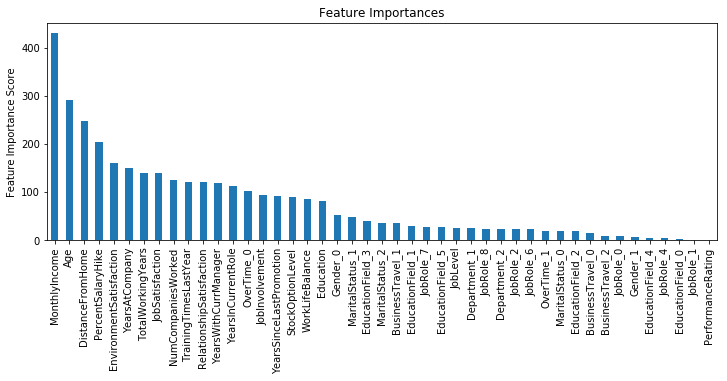

In [159]:
predictors = [x for x in df.columns if x not in ['Attrition']]
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
modelfit(xgb1, df, df_test, predictors)

In [160]:
param_test1={
    'max_depth':np.arange(1,15),
    'min_child_weight':np.arange(1,20)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=215,
                                                max_depth=5,
                                                min_child_weight=1,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test1,
                        scoring='roc_auc',n_jobs=-1,iid=False,cv=5)
gsearch1.fit(df[predictors],df['Attrition'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=215, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [161]:
gsearch1.best_params_,gsearch1.best_score_

({'max_depth': 1, 'min_child_weight': 12}, 0.8299442532594707)

In [162]:
param_test3 = {
    'gamma':np.arange(2.336,2.338,0.00001)
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=215,
                                                max_depth=1,
                                                min_child_weight=12,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test3,
                        scoring='roc_auc',n_jobs=-1,iid=False,cv=5)
gsearch3.fit(df[predictors],df['Attrition'])
gsearch3.best_params_,gsearch3.best_score_

({'gamma': 2.3368000000000051}, 0.8308999449760319)

227

Model Report
Accuracy : 0.8955
AUC Score (Train) : 0.875564


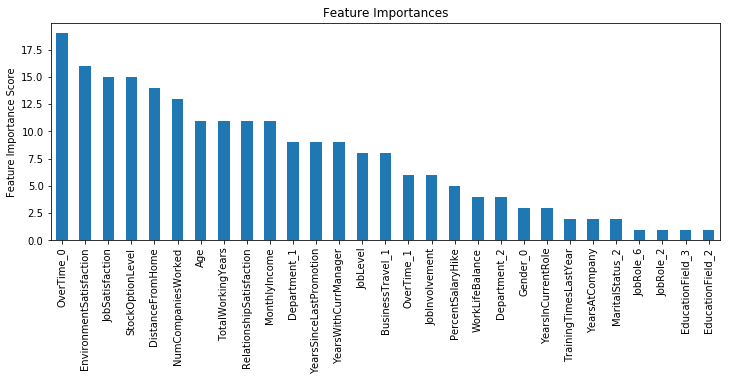

In [163]:
predictors = [x for x in df.columns if x not in ['Attrition']]
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=1,
                    min_child_weight=12,
                    gamma=2.3368,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
modelfit(xgb2, df, df_test, predictors)

In [164]:
param_test4 = {
    'subsample':np.arange(0.78,0.85,0.001),
    'colsample_bytree':np.arange(0.78,0.85,0.001)
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=227,
                                                max_depth=1,
                                                min_child_weight=12,
                                                gamma=2.3368,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=20,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test4,
                        scoring='roc_auc',n_jobs=-1,iid=False,cv=5)
gsearch4.fit(df[predictors],df['Attrition'])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.80000000000000004, 'subsample': 0.79800000000000004},
 0.8317406459254286)

In [165]:
param_test5 = {
    'reg_alpha':np.arange(0.0001,0.3,0.0001)
}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=227,
                                                max_depth=1,
                                                min_child_weight=12,
                                                gamma=2.3368,
                                                subsample=0.8,
                                                colsample_bytree=0.798,
                                                objective='binary:logistic',
                                                nthread=20,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test5,
                        scoring='roc_auc',n_jobs=-1,iid=False,cv=5)
gsearch5.fit(df[predictors],df['Attrition'])
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 0.1623}, 0.8317595545856415)

230

Model Report
Accuracy : 0.8964
AUC Score (Train) : 0.876118


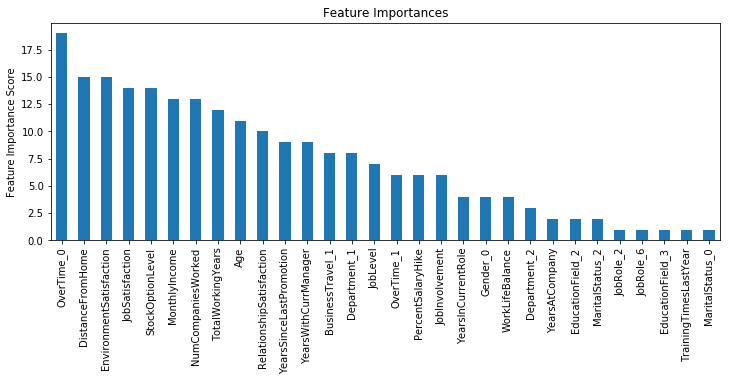

In [166]:
predictors = [x for x in df.columns if x not in ['Attrition']]
xgb3 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=1,
                    min_child_weight=12,
                    gamma=2.3368,
                    subsample=0.8,
                    colsample_bytree=0.798,
                    reg_alpha=0.1623,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
modelfit(xgb3, df, df_test, predictors)

1968

Model Report
Accuracy : 0.89
AUC Score (Train) : 0.872023


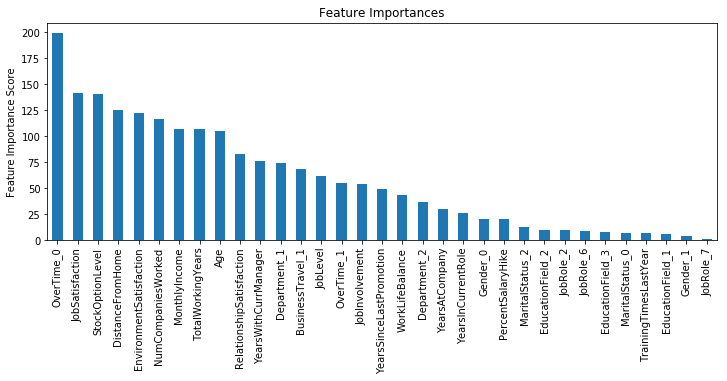

In [167]:
predictors = [x for x in df.columns if x not in ['Attrition']]
xgb4 = XGBClassifier(learning_rate=0.01,
                    n_estimators=8000,
                    max_depth=1,
                    min_child_weight=12,
                    gamma=2.3368,
                    subsample=0.8,
                    colsample_bytree=0.798,
                    reg_alpha=0.1623,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
modelfit(xgb4, df, df_test, predictors)

In [168]:
predictors = [x for x in df.columns if x not in ['Attrition']]
xgb5 = XGBClassifier(learning_rate=0.01,
                    n_estimators=1968,
                    max_depth=1,
                    min_child_weight=12,
                    gamma=2.3368,
                    subsample=0.8,
                    colsample_bytree=0.798,
                    reg_alpha=0.1623,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
xgb5.fit(df[predictors], df['Attrition'], eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.798,
       gamma=2.3368, learning_rate=0.01, max_delta_step=0, max_depth=1,
       min_child_weight=12, missing=None, n_estimators=1968, nthread=4,
       objective='binary:logistic', reg_alpha=0.1623, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [169]:
pd.DataFrame(xgb5.predict(df_test),columns=['result']).to_csv('result.csv',index=False)

In [170]:
xgb5.predict_proba(df_test)

array([[ 0.98744822,  0.01255176],
       [ 0.99300247,  0.00699753],
       [ 0.90632749,  0.09367254],
       [ 0.94678664,  0.05321338],
       [ 0.72509414,  0.27490586],
       [ 0.97616404,  0.02383597],
       [ 0.97416031,  0.02583967],
       [ 0.96013415,  0.03986586],
       [ 0.96181315,  0.03818684],
       [ 0.96147782,  0.03852219],
       [ 0.97659469,  0.02340532],
       [ 0.59550035,  0.40449968],
       [ 0.24136728,  0.75863272],
       [ 0.97134972,  0.02865027],
       [ 0.39647365,  0.60352635],
       [ 0.93580943,  0.06419057],
       [ 0.90087897,  0.09912103],
       [ 0.92381102,  0.07618896],
       [ 0.7357688 ,  0.2642312 ],
       [ 0.93121541,  0.06878459],
       [ 0.51311195,  0.48688805],
       [ 0.90942204,  0.09057797],
       [ 0.86129749,  0.13870253],
       [ 0.96827012,  0.0317299 ],
       [ 0.73848772,  0.26151231],
       [ 0.91503888,  0.08496113],
       [ 0.94366181,  0.05633822],
       [ 0.9412697 ,  0.0587303 ],
       [ 0.7368536 ,